In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import torch
import cv2
import os
from time import time
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset

In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"junaidio","key":"501b6112c0040dbe0263fb0a5da8ced2"}'}

In [3]:
import os
import zipfile

# Create a .kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the .kaggle folder
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [4]:
# List all datasets with "celeba" to confirm ID
!kaggle datasets list -s celeba

# Download the CelebA dataset (example using a popular one)
!kaggle datasets download -d jessicali9530/celeba-dataset


ref                                                   title                                              size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------  ------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
jessicali9530/celeba-dataset                          CelebFaces Attributes (CelebA) Dataset       1427750792  2018-06-01 20:08:48.043000         187027       1733  0.7647059        
quadeer15sh/celeba-face-recognition-triplets          CelebA Face Recognition Triplets              242120999  2023-09-24 13:41:22.197000           1763         57  0.8235294        
zuozhaorui/celeba                                     celeba                                       2835856818  2018-11-03 05:29:21.367000           1185         24  0.375            
badasstechie/celebahq-resized-256x256                 CelebA-HQ resized (256x256)    

In [5]:
# Unzip the dataset
!unzip -q celeba-dataset.zip -d celeba


In [21]:
class CelebADataset(Dataset):
    def __init__(self , folder_path , limit=60000 , img_size=128):
        self.img_size = img_size
        self.files_names = os.listdir(folder_path)[:limit]
        self.folder_path = folder_path

    def __len__(self):
        return len(self.files_names)

    def __getitem__(self , idx):
        img_name = self.files_names[idx]
        img_path = os.path.join(self.folder_path , img_name)

        # Load grayscale image (input) -> X
        X = cv2.imread(img_path , cv2.IMREAD_GRAYSCALE)
        X = cv2.resize(X , (self.img_size , self.img_size))
        X = X.astype('float32') / 255.0
        X = X.reshape(1 , self.img_size , self.img_size)

        y = cv2.imread(img_path)[: , : , ::-1] # BGR TO RGB
        y = cv2.resize(y , (self.img_size , self.img_size))
        y = y.astype('float32') / 255.0
        y = y.transpose(2 , 0 , 1) # HWC to CHW

        X = torch.tensor(X , dtype = torch.float32)
        y = torch.tensor(y , dtype = torch.float32)
        return X , y

folder_path = "/content/celeba/img_align_celeba/img_align_celeba"
dataset = CelebADataset(folder_path=folder_path, limit=60000, img_size=128)

In [22]:
train_loader = torch.utils.data.DataLoader(dataset , shuffle = True , batch_size = 64)
a , b = next(iter(train_loader))
a.shape , b.shape

(torch.Size([64, 1, 128, 128]), torch.Size([64, 3, 128, 128]))

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [24]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(1 , 64  , (3,3) , stride = 1 , padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = (2 , 2) , stride = 2) , # size -->> 64 * 64

            nn.Conv2d(64 , 128  , (3,3) , stride = 1 , padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size = (2 , 2) , stride = 2) ,# size -->> 32 * 32

            nn.Conv2d(128 , 256  , (3,3) , stride = 1 , padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = (2 , 2) , stride = 2), # size -->> 16 * 16

            nn.Conv2d(256 , 512  , (3,3) , stride = 1 , padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size = (2 , 2) , stride = 2), # size -->> 8 * 8

            nn.Conv2d(512 , 1024  , (3,3) , stride = 1 , padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size = (2 , 2) , stride = 2) ,# size -->> 4x4


        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(1024 , 512 , (3,3), stride = 2 , padding = 1 , output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(512 , 256 , (3,3), stride = 2 , padding = 1 , output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256 , 128 , (3,3), stride = 2 , padding = 1 , output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128 , 64 , (3,3), stride = 2 , padding = 1 , output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64 , 3 , (3,3), stride = 2 , padding = 1 , output_padding = 1),
            nn.Sigmoid()


        )

    def forward(self , x):
        out = self.Encoder(x)
        out = self.Decoder(out)
        return out

In [25]:
model = Autoencoder()
model = model.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)


In [26]:
accuracy_scores = []
train_loss = []
num_epochs = 25

def compute_accuracy(pred, target, tolerance=0.05):
    return ((torch.abs(pred - target) < tolerance).float().mean().item())

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    c = 0

    for gray, col in tqdm(train_loader, desc=f"Epoch {epoch}"):
        gray, col = gray.to(device), col.to(device)

        optimizer.zero_grad()
        y_pred = model(gray)
        loss = criterion(y_pred, col)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += compute_accuracy(y_pred, col)
        c += 1

    avg_loss = epoch_loss / c
    avg_acc = epoch_acc / c
    train_loss.append(avg_loss)

    if epoch % 10 == 0:
        accuracy_scores.append(avg_acc)
        print(f"Epoch {epoch} - Loss: {avg_loss:.4f} - Accuracy: {avg_acc:.4f}")
    else:
        print(f"Epoch {epoch} - Loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 938/938 [03:39<00:00,  4.27it/s]


Epoch 1 - Loss: 0.0135


Epoch 2: 100%|██████████| 938/938 [03:40<00:00,  4.26it/s]


Epoch 2 - Loss: 0.0087


Epoch 3: 100%|██████████| 938/938 [03:41<00:00,  4.24it/s]


Epoch 3 - Loss: 0.0078


Epoch 4: 100%|██████████| 938/938 [03:41<00:00,  4.24it/s]


Epoch 4 - Loss: 0.0072


Epoch 5: 100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 5 - Loss: 0.0068


Epoch 6: 100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 6 - Loss: 0.0066


Epoch 7: 100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 7 - Loss: 0.0063


Epoch 8: 100%|██████████| 938/938 [03:41<00:00,  4.24it/s]


Epoch 8 - Loss: 0.0061


Epoch 9: 100%|██████████| 938/938 [03:40<00:00,  4.26it/s]


Epoch 9 - Loss: 0.0058


Epoch 10: 100%|██████████| 938/938 [03:39<00:00,  4.28it/s]


Epoch 10 - Loss: 0.0055 - Accuracy: 0.6506


Epoch 11: 100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 11 - Loss: 0.0051


Epoch 12: 100%|██████████| 938/938 [03:41<00:00,  4.24it/s]


Epoch 12 - Loss: 0.0048


Epoch 13: 100%|██████████| 938/938 [03:40<00:00,  4.26it/s]


Epoch 13 - Loss: 0.0046


Epoch 14: 100%|██████████| 938/938 [03:41<00:00,  4.24it/s]


Epoch 14 - Loss: 0.0043


Epoch 15: 100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 15 - Loss: 0.0041


Epoch 16: 100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 16 - Loss: 0.0040


Epoch 17: 100%|██████████| 938/938 [03:41<00:00,  4.24it/s]


Epoch 17 - Loss: 0.0038


Epoch 18: 100%|██████████| 938/938 [03:41<00:00,  4.24it/s]


Epoch 18 - Loss: 0.0037


Epoch 19: 100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 19 - Loss: 0.0036


Epoch 20: 100%|██████████| 938/938 [03:40<00:00,  4.26it/s]


Epoch 20 - Loss: 0.0035 - Accuracy: 0.7162


Epoch 21: 100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 21 - Loss: 0.0034


Epoch 22: 100%|██████████| 938/938 [03:40<00:00,  4.26it/s]


Epoch 22 - Loss: 0.0033


Epoch 23: 100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 23 - Loss: 0.0032


Epoch 24: 100%|██████████| 938/938 [03:41<00:00,  4.24it/s]


Epoch 24 - Loss: 0.0032


Epoch 25: 100%|██████████| 938/938 [03:40<00:00,  4.25it/s]

Epoch 25 - Loss: 0.0031


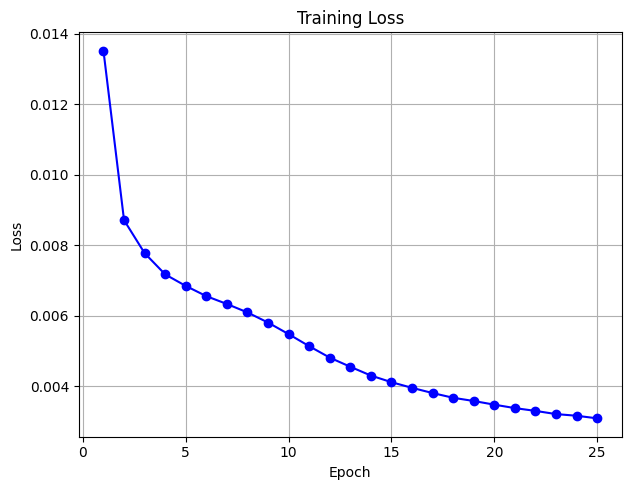

In [27]:
epochs = list(range(1, num_epochs + 1))
acc_epochs = list(range( num_epochs + 1))

# Plot
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


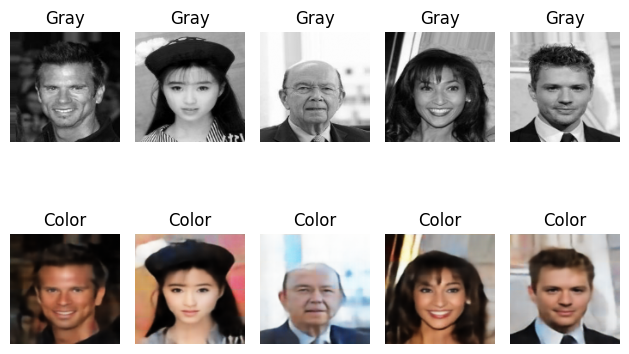

In [28]:
a, b = next(iter(train_loader))
model = model.to('cpu')
y_pred = model(a)
img_size = 128

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(a[i].reshape(img_size, img_size), cmap='gray')
    plt.title('Gray')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(y_pred[i].detach().numpy().transpose(1, 2, 0))
    plt.title('Color')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
torch.save(model.state_dict(), "colorization_model.pth")